# A Markovian model of evolving world IO network
https://sevamoo.github.io/Markovian_IO_SI_PLOSONE/

In [2]:
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
import sompy as SOM
from pylab import matshow, savefig
from scipy.linalg import norm
import time

## Supporting Functions

In [3]:
def update_by_momentum(series, span, pred_period):
    result = []  # first value is same as series
    vals = series[-span - 1:]
    for n in range(pred_period):
        momentum_avg = np.mean(np.diff(vals))
        result.append(vals[-1] + momentum_avg)
        vals[-1] = result[-1]

    return result

In [4]:
def aggregate_economy_int_consumptions(WIOT):
    economy_n = 41
    industry_n = 35
    economy_int_consumptions_n = 1
    economy_produsction_costs_n = 1
    states_n = economy_n * industry_n + economy_n * 1 + industry_n * 1

    economy_income = np.zeros((economy_n * industry_n, economy_n))
    economy_int_consumptions = np.zeros((economy_n * industry_n, economy_n))
    ind = economy_n * industry_n
    for i in range(economy_n):
        # This data are stored in the last columns on the right side of WIOD.
        # They are in five subcategory that here we just sum them as the final consumption of the government (inc. households)
        col = i * 5 + ind
        economy_int_consumptions[:, i] = WIOT[:, col:col + 5].sum(axis=1)

    # I don't know why but sometimes it gets a bit negative?!!! due to change in inventory (5th column of economy consum)
    economy_int_consumptions[economy_int_consumptions < 0] = 0

    # This is Tax, Payments, ...
    industry_production_costs = np.around(
        WIOT[:].sum(axis=1) - WIOT[:, :economy_n * industry_n].sum(axis=0), decimals=5)

    return (economy_int_consumptions, industry_production_costs)

In [5]:
def build_markov_chain_Dense(
        Q,
        WIOT,
        economy_n,
        industry_n,
        economy_int_consumptions,
        industry_production_costs,
):
    e0 = time.time()
    eps = .001

    for i in range(0, economy_n * industry_n):

        # For industry interactions
        for j in range(0, economy_n * industry_n):
            Q[i, j] = WIOT[j, i]

        # For payments of industry to its economy: This is the source of income for the economy
        economy_ind_industry = i // industry_n
        Q[i, economy_n * industry_n + economy_ind_industry] = industry_production_costs[i]

        # For economy's costs (i.e. consumptions)
        ind_economy_inTM = economy_n * industry_n

        for j in range(economy_n):
            Q[j + ind_economy_inTM, i] = economy_int_consumptions[i, j]

    # We have row stochastic matrix! In the paper we have column stochastic!
    singular_industries = []
    for i in range(Q.shape[0]):
        s = sum(Q[i])

        if np.sum(Q[i] > 0) == 1:
            if np.where(Q[i] > 0) == i:

                # means absorbing state
                Q[i] = eps
                Q[i, i] = 1.
                s = sum(Q[i])
                Q[i] = np.divide(Q[i], s)
            else:
                pass
            # print(np.where(Q[i] > 0), i, np.sum(Q[:, i] > 0))

        if s == 0:
            singular_industries.append(i % economy_n)
            Q[i] = eps
            Q[i, i] = 1.
            s = sum(Q[i])
            Q[i] = np.divide(Q[i], s)
        else:
            Q[i] = np.divide(Q[i], s)
    print('Making the TM in {} second'.format(time.time() - e0))

    return (np.around(Q, decimals=10), list(np.unique(singular_industries)))

In [6]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

In [7]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [8]:
# Sensitivity analysis on a single node
def change_node(M,
                economy_to_perturb=None,
                industry_to_perturb=None,
                percent=10):
    MC = M.copy()
    
    ind_indusrty_to_perturb_from_their_economy = []
    ind_indusrty_to_perturb_from_specific_industry = []

    if industry_to_perturb == industry_n:
        i = industry_n * economy_n + economy_to_perturb
    else:
        i = industry_to_perturb + (economy_to_perturb) * industry_n
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

## Load Dataset

In [9]:
economy_n = 41
industry_n = 35
header = pd.read_csv('./markov/Data/WIOD/header.csv', header=None)
economy_names = header.values[1, range(0, 1435, 35)]
industry_names = header.values[0, range(0, 35)]

In [10]:
Countries = pd.read_csv("./markov/Data/WIOD/Economies_Names.csv")

In [11]:
# We calculated this before from the WIOD, for GDP calculations
VA = pd.read_csv('./markov/Data/WIOD/VAs.csv', index_col=[0])

In [12]:
WIO = list()
for i in range(1995, 2012):
    d = pd.read_csv(
        './markov/Data/WIOD/wiot' + str(i) + '_row_apr12.csv', header=[0, 1, 2])
    WIO.append(d.values[:])
    print(i, d.shape)

1995 (1435, 1640)
1996 (1435, 1640)
1997 (1435, 1640)
1998 (1435, 1640)
1999 (1435, 1640)
2000 (1435, 1640)
2001 (1435, 1640)
2002 (1435, 1640)
2003 (1435, 1640)
2004 (1435, 1640)
2005 (1435, 1640)
2006 (1435, 1640)
2007 (1435, 1640)
2008 (1435, 1640)
2009 (1435, 1640)
2010 (1435, 1640)
2011 (1435, 1640)


## Using Power Iteration to calculate the steady state probabilities, Pi

In [13]:
Pi = []
TMs = []
Mixing_times = []
singular_ids = []

for i, WIOT in enumerate(WIO):
    economy_int_consumptions, industry_production_costs = aggregate_economy_int_consumptions(WIOT)
    economy_n = 41
    industry_n = 35
    states_n = economy_n * industry_n + economy_n
    TM = np.zeros((states_n, states_n))
    TM, singular_id = build_markov_chain_Dense(TM, WIOT, economy_n, industry_n,
                                               economy_int_consumptions,
                                               industry_production_costs)
    TMs.append(TM)
    singular_ids.extend(singular_id)
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

singular_ids = np.unique(singular_ids)

Making the TM in 1.0270366668701172 second
Iterating 291 times in 0.18399786949157715
Making the TM in 1.065000057220459 second
Iterating 257 times in 0.15500426292419434
Making the TM in 1.100038766860962 second
Iterating 250 times in 0.1500086784362793
Making the TM in 1.206000566482544 second
Iterating 258 times in 0.14000487327575684
Making the TM in 1.0490307807922363 second
Iterating 261 times in 0.14499902725219727
Making the TM in 1.054999589920044 second
Iterating 241 times in 0.13000702857971191
Making the TM in 1.0309982299804688 second
Iterating 229 times in 0.13301515579223633
Making the TM in 1.0550458431243896 second
Iterating 229 times in 0.1260066032409668
Making the TM in 1.0500388145446777 second
Iterating 222 times in 0.11999797821044922
Making the TM in 1.030000925064087 second
Iterating 208 times in 0.12001657485961914
Making the TM in 1.0399930477142334 second
Iterating 189 times in 0.11701774597167969
Making the TM in 1.0220363140106201 second
Iterating 173 time

## Average mixing time of Markov chains as an aggregate index of globalization

In [14]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 100
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in range(n):
    for j in range(len(TMs)):
        t, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

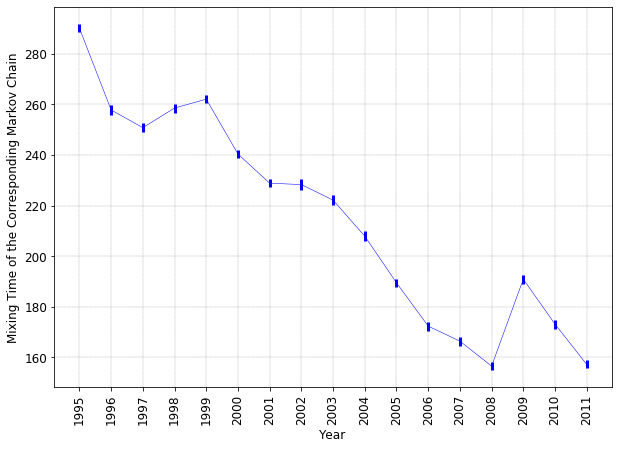

In [19]:
fig = plt.figure(figsize=(10, 7));
yerr = 3 * Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(1, 18),
    Mixing_times_n_times.mean(axis=0),
    yerr=yerr,
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.51,
    elinewidth=3)
plt.xticks(range(1, 18), range(1995, 2012))
label = range(1995, 2012)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
plt.xlabel('Year')
plt.xticks(range(1, 18), label, rotation=90)

plt.grid(linewidth=.31, color='gray', linestyle='--')
# path = './markov/Images/Mixing_Time.tiff'
# fig.savefig(path,dpi=300)
plt.show();